<a href="https://colab.research.google.com/github/MathieuGrosso/projet-dima-/blob/main/Extracting_features_Material_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install pymicro

In [4]:
import sys
import os
import functools
import pathlib
import pickle
from google.colab import drive
import functools
import pathlib
import pickle

import numpy as np
import pymicro
from pymicro.file import file_utils
import IPython
from IPython.display import clear_output
import matplotlib
from matplotlib import pyplot as plt, cm
import numpy as np 

from PIL import Image
from array import *
from random import shuffle
import numpy as np
import matplotlib
from matplotlib import pyplot as plt, cm

import seaborn as sns
from sklearn.manifold import TSNE, Isomap, MDS
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve,auc,roc_auc_score

In [5]:
print(sys.version)

3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]


#Save Data, Load them, and crops them

## Crops the data for anomaly detection

In [6]:
from google.colab import drive
drive.mount('/content/drive')

!ls

Mounted at /content/drive
drive  sample_data


In [7]:
#Obtenir les images normales: 
%cd /content/drive/MyDrive/DIMA /Datasets


/content/drive/MyDrive/DIMA /Datasets


In [8]:
data_dir = pathlib.Path('/content/drive/MyDrive/DIMA /Datasets/Data_big_raw') #changer la data_dir #grosse images
#data_dir=pathlib.Path('/content/drive/MyDrive/DIMA /Datasets/Data_reduced') #petites images
data_filepath = data_dir / "pa66.raw"
labels_filepath = data_dir / "pa66.ground_truth.raw"


In [9]:
#ouvrir les fichiers raw: 
import os
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt

from google.colab import files

src = list(files.upload().values())[0] 
open('read_raw.py','wb').write(src) 

from read_raw import HST_read



Saving read_raw.py to read_raw (2).py


In [10]:
# this is just a trick to give names to these values
# and put them together
class label:
    matrix = 0
    fiber = 1
    porosity = 2

labels_list = [0, 1, 2]

dimensions = (1300, 1040, 1900)
dtype = "uint8"

# prefill the function `HST_read`
hst_read = functools.partial(
    file_utils.HST_read,
    autoparse_filename=False,  # the file names are not properly formatted
    data_type=dtype,
    dims=dimensions,
    verbose=True,)

In [11]:
data = hst_read(data_filepath)
labels = hst_read(labels_filepath)

data type is uint8
volume size is 1300 x 1040 x 1900
reading volume... from byte 0
data type is uint8
volume size is 1300 x 1040 x 1900
reading volume... from byte 0


In [12]:
assert data.shape == labels.shape

In [13]:
random_state = np.random.RandomState(42)

In [14]:
crop_size = 128  # 128 x 128 pixels square
n_crops = 1000
volume_shape = data.shape
axes_limits = (
    # x and y are smaller because i will get a random
    # coordinate of the left most and upper most pixel of the crop
    (0, volume_shape[0] - crop_size),  # x-axis
    (0, volume_shape[1] - crop_size),  # y-axis
    (0, volume_shape[2]),  # z-axis
)


### crops of data without porosity : 


In [15]:
def does_not_have_porosity(label_crop_: np.ndarray) -> bool:
    return np.all(label_crop_ != label.porosity)

In [16]:
condition = does_not_have_porosity

In [17]:
print(f"found: 0")
crops = []

while len(crops) < n_crops:
    z = random_state.randint(*axes_limits[2])  # min / max in z
    x0 = random_state.randint(*axes_limits[0])
    y0 = random_state.randint(*axes_limits[1])
    x1, y1 = x0 + crop_size, y0 + crop_size
    
    labels_crop = labels[x0:x1, y0:y1, z]
    data_crop = data[x0:x1, y0:y1, z]
    
    if condition(labels_crop):
        crops.append({
            "data": data_crop.copy(),
            "labels": labels_crop.copy(),
        })
        clear_output()
        print(f"found: {len(crops)}")

found: 1000


In [18]:
without_porosity = crops

##crops of data with porosity: 

In [19]:
def has_porosity(label_crop_: np.ndarray) -> bool:
    return np.any(label_crop_ == label.porosity)

In [20]:
condition = has_porosity

In [21]:
print(f"found: 0")
crops = []

while len(crops) < n_crops:
    z = random_state.randint(*axes_limits[2])  # min / max in z
    x0 = random_state.randint(*axes_limits[0])
    y0 = random_state.randint(*axes_limits[1])
    x1, y1 = x0 + crop_size, y0 + crop_size
    
    labels_crop = labels[x0:x1, y0:y1, z]
    data_crop = data[x0:x1, y0:y1, z]
    
    if condition(labels_crop):
        crops.append({
            "data": data_crop.copy(),
            "labels": labels_crop.copy(),
        })
        clear_output()
        print(f"found: {len(crops)}")


found: 1000


In [22]:
with_porosity = crops

## Save in drive and load them : 


In [23]:
len(without_porosity), len(with_porosity)

(1000, 1000)

In [24]:
without_porosity_folder = (data_dir / f"{crop_size}px-images-WITHOUT-porosity").resolve()
with_porosity_folder = (data_dir / f"{crop_size}px-images-WITH-porosity").resolve()

In [25]:
without_porosity_folder.mkdir(exist_ok=True)
with_porosity_folder.mkdir(exist_ok=True)

In [26]:
list_crops = without_porosity
folder = without_porosity_folder

In [27]:
for idx, crop in enumerate(list_crops):
    data_png_filepath = (folder / f"{idx:06d}-data.png")
    labels_png_filepath = (folder / f"{idx:06d}-labels.png")
    crop_data = crop["data"]
    crop_labels = crop["labels"]
    matplotlib.image.imsave(data_png_filepath, crop_data, cmap=cm.gray, vmin=0, vmax=255)    
    matplotlib.image.imsave(labels_png_filepath, crop_labels, cmap=cm.gray, vmin=0, vmax=2)

In [28]:
list_crops = with_porosity
folder = with_porosity_folder

In [29]:
for idx, crop in enumerate(list_crops):
    data_png_filepath = (folder / f"{idx:06d}-data.png")
    labels_png_filepath = (folder / f"{idx:06d}-labels.png")
    crop_data = crop["data"]
    crop_labels = crop["labels"]
    matplotlib.image.imsave(data_png_filepath, crop_data, cmap=cm.gray, vmin=0, vmax=255)    
    matplotlib.image.imsave(labels_png_filepath, crop_labels, cmap=cm.gray, vmin=0, vmax=2)    

# Preparation of the study: 


##build the data for the training and testing set: 

In [31]:
#load google drive and the file
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/DIMA /Datasets/Data_big_raw")
%cd /content/drive/MyDrive/DIMA /Datasets/Data_big_raw
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DIMA /Datasets
 128px-images-WITHOUT-porosity/           model2/
 128px-images-WITH-porosity/              model3/
 dataset_anormal_origin_test_32_x.npy     model4/
 dataset_anormal_origin_test_32_y.npy     model5/
 dataset_anormal_rotated_test_32_x.npy    model6/
 dataset_anormal_rotated_test_32_y.npy    pa66.ground_truth.raw
 dataset_normal_deformed_train_32_x.npy   pa66.ground_truth.raw.info
 dataset_normal_deformed_train_32_y.npy   pa66.raw
 dataset_normal_origin_test_32_x.npy      pa66.raw.info
 dataset_normal_origin_test_32_y.npy      pa66.test.error_volume.raw
 dataset_normal_origin_train_32_x.npy     pa66.test.error_volume.raw.info
 dataset_normal_origin_train_32_y.npy     pa66.test.prediction.raw
 dataset_normal_rotated_test_32_x.npy     pa66.test.prediction.raw.info
 dataset_normal_rotated_test_32_y.npy     __pycache__/
 datas

In [32]:
def create_data_set():
  
  data_dir = pathlib.Path(".").resolve()
  file_list = os.listdir(data_dir)
  file_list_train = {'x' : [], 'y' : []}
  file_list_test = {'x' : [], 'y' : []}

  for file_name in file_list:
      if file_name[-4:] == '.npy':
        key = file_name[-5]
        if 'train' in file_name:
          file_list_train[key].append(file_name)
        elif 'test' in file_name:
          file_list_test[key].append(file_name)
  
  train = {}
  test = {}

  for key in ['x', 'y']:
    train_path = (data_dir / file_list_train[key][0]).resolve()
    test_path = (data_dir / file_list_test[key][0]).resolve()
    train_data = np.load(train_path)
    test_data = np.load(test_path)
    train[key] = train_data
    test[key] = test_data

  if len(file_list_train) > 1:
    for key in ['x', 'y']:
      for i in range(len(file_list_train[key]) - 1):
        path = (data_dir / file_list_train[key][i+1]).resolve()
        data = np.load(path)
        train[key] = np.append(train[key], data, axis=0)

  if len(file_list_test) > 1:
    for key in ['x', 'y']:
      for i in range(len(file_list_test[key]) - 1):
        path = (data_dir / file_list_test[key][i+1]).resolve()
        data = np.load(path)
        test[key] = np.append(test[key], data, axis=0)

  randnum1 = np.random.randint(0,100)
  np.random.seed(randnum1)
  np.random.shuffle(train['x'])
  np.random.seed(randnum1)
  np.random.shuffle(train['y'])
  randnum2 = np.random.randint(0,100)
  np.random.seed(randnum2)
  np.random.shuffle(test['x'])
  np.random.seed(randnum2)
  np.random.shuffle(test['y'])

  train['x'] = train['x'].astype('float32') / 255
  test['x'] = test['x'].astype('float32') / 255
  train['x'] = np.expand_dims(train['x'], axis=3)
  test['x'] = np.expand_dims(test['x'], axis=3)

  return (train['x'],train['y']),(test['x'],test['y'])

<class 'numpy.ndarray'>
(16800, 32, 32, 1)
(16800,)
(0,)
(9600, 32, 32, 1)
(9600,)
(4800,)


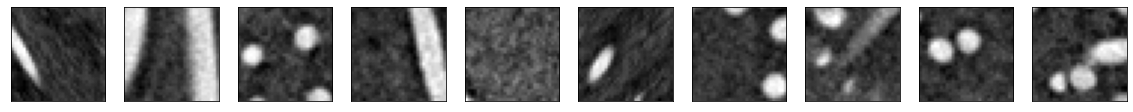

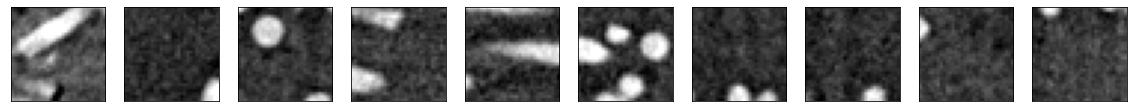

In [33]:
# Get the the training and the test dataset
(x_train, y_train), (x_test, y_test) = create_data_set()

print(type(x_train))
print(x_train.shape)
print(y_train.shape)
print(y_train[y_train==0].shape)
print(x_test.shape)
print(y_test.shape)
print(y_test[y_test==0].shape)

x_test_anormal = x_test[y_test==0]
# Display some NORMAL images
n = 10  # how many images we will display
plt.figure(figsize=(20, 20))
for i in range(n):
    # display original
    ax = plt.subplot(5, n, i + 1)
    plt.imshow(x_train[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(20, 20))
for i in range(n):
    # display original
    ax = plt.subplot(5, n, i + 1)
    plt.imshow(x_test_anormal[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


## function for creating the class

## Function for evaluating performance 

In [ ]:
def construct_model():

def ...

## study for each level

### Analyse et distance de mahalanobis

In [ ]:
#mahalanobis distance :
errs=anomaly_detect_mahalanobis(x_train_features=x_train_features, x_test_features=x_test_features)

In [ ]:
#compute roc_auc_score: 
from sklea ...
res_maha=roc_auc_score(y_test==0,errs)